# GO terms for differentially expressed proteins
In this notebook, we'll retrieve GO terms for proteins that are differentially expressed in the two conditions.

In [1]:
import pandas as pd
import requests, sys
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

## Read in the data

In [2]:
two_vs_21 = pd.read_csv('../data/proteomics/2_vs_21_O2_de_results_median_permuatation_test.csv', header=4).iloc[:-1]
forty_vs_21 = pd.read_csv('../data/proteomics/40_vs_21_O2_de_results_median_permutation_test.csv', header=4).iloc[:-1]

Drop the `[#]` from accession numbers that had the multiple option dropdown in Scaffold:

In [3]:
two_vs_21["Accession Number"] = two_vs_21["Accession Number"].str.split('[').str[0].str.strip()
two_vs_21["Accession Number"] = two_vs_21["Accession Number"].str.split('(').str[0].str.strip()
forty_vs_21["Accession Number"] = forty_vs_21["Accession Number"].str.split('[').str[0]
forty_vs_21["Accession Number"] = forty_vs_21["Accession Number"].str.split('(').str[0].str.strip()

Put in 0's for p-values with `< 0.001` and cast to float:

In [4]:
two_vs_21["Permutation Test (p-value) Benjamini-Hochberg (p < 0.00287)"] = two_vs_21["Permutation Test (p-value) Benjamini-Hochberg (p < 0.00287)"].replace('< 0.0001', 0).astype('float64')
forty_vs_21["Permutation Test (p-value) Benjamini-Hochberg (p < 0.00598)"] = forty_vs_21["Permutation Test (p-value) Benjamini-Hochberg (p < 0.00598)"].replace('< 0.0001', 0).astype('float64')

Keep only the significant ones:

In [5]:
two_signif = 0.00287
forty_signif = 0.00598

In [6]:
two_signif_access = two_vs_21[two_vs_21["Permutation Test (p-value) Benjamini-Hochberg (p < 0.00287)"] < two_signif]["Accession Number"].tolist()
forty_signif_access = forty_vs_21[forty_vs_21["Permutation Test (p-value) Benjamini-Hochberg (p < 0.00598)"] < forty_signif]["Accession Number"].tolist()

## Query QuickGO
For each set of DE proteins, we want to get the GO terms for each protein in the set. We'll do this by querying the QuickGO database with their REST API. We can only query 500 at a time.

In [7]:
len(two_signif_access), len(forty_signif_access)

(268, 556)

Filter out any IDs with special characters, as that'll break the query:

In [8]:
two_signif_access_filtered = [i for i in two_signif_access if all(c.isalnum() for c in i)]
two_signif_access_dropped = [i for i in two_signif_access if not all(c.isalnum() for c in i)]
print(f'Accession numbers {two_signif_access_dropped} were dropped from 2% vs 21% O2')

forty_signif_access_filtered = [i for i in forty_signif_access if all(c.isalnum() for c in i)]
forty_signif_access_dropped = [i for i in forty_signif_access if not all(c.isalnum() for c in i)]
print(f'Accession numbers {forty_signif_access_dropped} were dropped from 40% vs 21% O2')

Accession numbers ['CON__P00761'] were dropped from 2% vs 21% O2
Accession numbers [] were dropped from 40% vs 21% O2


Formulate the queries:

In [9]:
two_search_list = ','.join(two_signif_access_filtered)
two_query = f'https://www.ebi.ac.uk/QuickGO/services/annotation/search?geneProductId={two_search_list}'

forty_search_list1 = ','.join(forty_signif_access_filtered[:500])
forty_search_list2 = ','.join(forty_signif_access_filtered[500:])
forty_query1 = f'https://www.ebi.ac.uk/QuickGO/services/annotation/search?geneProductId={forty_search_list1}'
forty_query2 = f'https://www.ebi.ac.uk/QuickGO/services/annotation/search?geneProductId={forty_search_list2}'

Make the resuests:

In [10]:
def getGOterms(query):
    """
    Get GO terms from a mmultiple-page search result.
    """
    # Check number of pages
    r = requests.get(query, headers={ "Accept" : "application/json"})
    if not r.ok:
      r.raise_for_status()
      sys.exit()
    responseBody = r.json()
    num_pages = responseBody["pageInfo"]["total"]
    print(f'There are {num_pages} pages of responses.')

    # Get all results
    overall_jsons = []
    for i in tqdm(range(num_pages)):
        query_w_page = query + '&page=' + str(i + 1)
        r = requests.get(query_w_page, headers={ "Accept" : "application/json"})
        if not r.ok:
          r.raise_for_status()
          sys.exit()
        responseBody = r.json()
        overall_jsons.append(responseBody)

    return overall_jsons

In [11]:
two_jsons = getGOterms(two_query)

There are 148 pages of responses.


100%|██████████| 148/148 [01:10<00:00,  2.10it/s]


In [13]:
two_jsons

[{'numberOfHits': 3694,
  'results': [{'id': 'UniProtKB:A0A178U807!810030905',
    'geneProductId': 'UniProtKB:A0A178U807',
    'qualifier': 'enables',
    'goId': 'GO:0003677',
    'goName': None,
    'goEvidence': 'IEA',
    'goAspect': 'molecular_function',
    'evidenceCode': 'ECO:0007322',
    'reference': 'GO_REF:0000043',
    'withFrom': [{'connectedXrefs': [{'db': 'UniProtKB-KW',
        'id': 'KW-0238'}]}],
    'taxonId': 3702,
    'taxonName': None,
    'assignedBy': 'UniProt',
    'extensions': None,
    'targetSets': None,
    'symbol': 'At5g18550',
    'date': '20241216',
    'synonyms': None,
    'name': None},
   {'id': 'UniProtKB:A0A178U807!810030906',
    'geneProductId': 'UniProtKB:A0A178U807',
    'qualifier': 'enables',
    'goId': 'GO:0003729',
    'goName': None,
    'goEvidence': 'IEA',
    'goAspect': 'molecular_function',
    'evidenceCode': 'ECO:0000256',
    'reference': 'GO_REF:0000117',
    'withFrom': [{'connectedXrefs': [{'db': 'ARBA', 'id': 'ARBA00028398

In [12]:
forty_jsons = getGOterms(forty_query1) + getGOterms(forty_query2)

There are 287 pages of responses.


  0%|          | 1/287 [00:00<04:41,  1.02it/s]


KeyboardInterrupt: 

Now we need to parse the outputs:

In [14]:
def getGOterms(responseBody_list):
    """
    Parse the output of a multi-protein GO term query.

    parameters:
        responseBody_list, list of dict: list of json-formatted response with exit code 200
        
    returns:
        go_terms, dict: keys are protein IDs, values are dicts where keys are evidence codes and
            values are lists of GO terms
    """
    go_terms = defaultdict(lambda: defaultdict(list))
    for page in tqdm(responseBody_list):
        for res in page["results"]:
            go_terms[res['geneProductId']][res['goEvidence']].append(res['goId'])
    return go_terms

def getGOaspects(responseBody_list):
    """
    Get the goAspect values for all GO terms in a query response

    parameters:
        responseBody_list, list of dict: list of json-formatted response with exit code 200

    returns:
        goAspects, dict: keys are GO ID's, values are GO aspects
    """
    goAspects = {}
    for page in tqdm(responseBody_list):
        for res in page["results"]:
            goAspects[res['goId']] = res['goAspect']
    return goAspects

In [15]:
two_goAspects = getGOaspects(two_jsons)
two_goTerms = getGOterms(two_jsons)

100%|██████████| 148/148 [00:00<00:00, 73479.76it/s]


In [16]:
two_goTerms

defaultdict(<function __main__.getGOterms.<locals>.<lambda>()>,
            {'UniProtKB:A0A178U807': defaultdict(list,
                         {'IEA': ['GO:0003677',
                           'GO:0003729',
                           'GO:0008270',
                           'GO:0046872']}),
             'UniProtKB:A0A178VTI3': defaultdict(list,
                         {'IEA': ['GO:0004386',
                           'GO:0005524',
                           'GO:0016787',
                           'GO:0042393',
                           'GO:0006355',
                           'GO:0048731',
                           'GO:0005634']}),
             'UniProtKB:A0A1I9LLC0': defaultdict(list,
                         {'IEA': ['GO:0003723']}),
             'UniProtKB:A0A1I9LNT2': defaultdict(list,
                         {'IEA': ['GO:0016491', 'GO:0016616']}),
             'UniProtKB:A0A1I9LTL2': defaultdict(list,
                         {'IEA': ['GO:0016740',
                          

In [44]:
forty_goAspects = getGOaspects(forty_jsons)
forty_goTerms = getGOterms(forty_jsons)

100%|██████████| 320/320 [00:00<00:00, 65974.11it/s]


GO terms are supported with [evidence codes](https://geneontology.org/docs/guide-go-evidence-codes/). It looks at a glance like most of our GO terms have the code IEA, which is the only one that is not manually reviewed, as they are predicted computationally (as opposed to computational evidence codes that come from manual review of papers that used computational methods). Let's look at the distribution of evidence codes for each group of DE proteins:

In [50]:
two_go_codes = defaultdict(int)
for prot, go_terms in two_goTerms.items():
    for code, terms in go_terms.items():
        two_go_codes[code] += len(terms)
forty_go_codes = defaultdict(int)
for prot, go_terms in forty_goTerms.items():
    for code, terms in go_terms.items():
        forty_go_codes[code] += len(terms)
all_codes = list(set(list(two_go_codes.keys()) + list(forty_go_codes.keys())))

I want to be able to include a table of what the terms mean in my figure, so let's quickly parse the HTML table from [this website](http://www.candidagenome.org/cgi-bin/GO/goEvidence.pl):

In [116]:
evidence_code_definitions = pd.read_html('http://www.candidagenome.org/cgi-bin/GO/goEvidence.pl')[1].drop("Examples", axis=1)
evidence_code_definitions = pd.Series(evidence_code_definitions['Definition'].values, index=evidence_code_definitions['Code']).to_dict()
# Manually add definitions missing from the table
evidence_code_definitions['HEP'] = 'Inferred from High Throughput Expression Pattern'
evidence_code_definitions['IPI'] = 'Inferred from Physical Interaction'
evidence_code_definitions['HDA'] = 'Inferred from High Throughput Direct Assay'
evidence_code_definitions['EXP'] = 'Inferred from Experiment'
evidence_code_definitions['IBA'] = 'Inferred from Biological aspect of Ancestor'

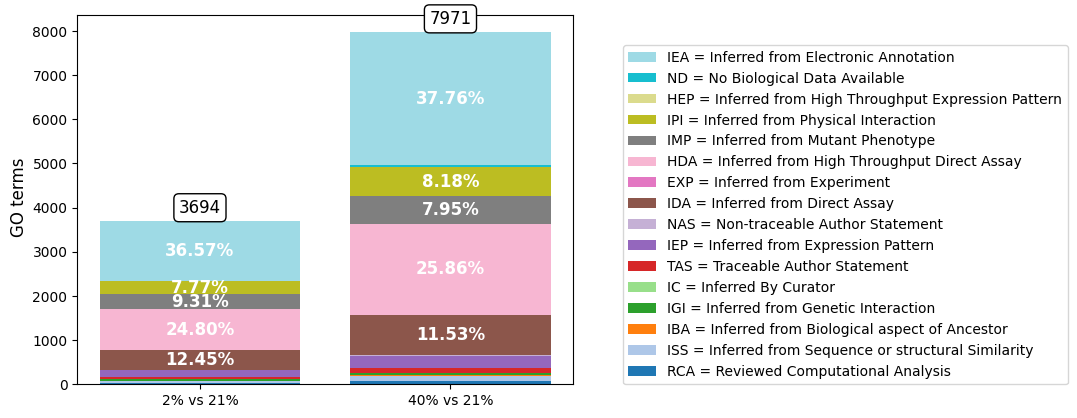

In [138]:
colors = {code: c for code, c in zip(all_codes, plt.cm.tab20(np.linspace(0, 1, len(all_codes))))}

# Sort evidence code definition tables to match ordder of legend
evidence_code_definitions = {code: evidence_code_definitions[code] for code in colors.keys()}

# Re-order dicts
two_ordered = {code: two_go_codes[code] for code in colors.keys()}
forty_ordered = {code: forty_go_codes[code] for code in colors.keys()}
to_plot = {'2% vs 21%': two_ordered, '40% vs 21%': forty_ordered}

fig, ax = plt.subplots(1)
for ordered_name, ordered in to_plot.items():
    total_terms = sum(ordered.values())
    bottom = np.zeros(1)
    ordered = to_plot[ordered_name]
    for code, val in ordered.items():
        bar, = ax.bar(ordered_name, val, color=colors[code], label=code, bottom=bottom)
        if (bar.get_height()/total_terms)*100 > 5:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                0.5*bar.get_height() + bar.get_y(),
                f'{(bar.get_height()/total_terms)*100:.2f}%',
                ha='center',
                va='center',
                color='w',
                weight='bold',
                size=12
            )
        
        centered_x = bar.get_x() + bar.get_width() / 2
        top_y = bar.get_height() + bar.get_y()
        bottom += val
    ax.text(centered_x, top_y + 100, sum(ordered.values()), bbox={'boxstyle':'round', 'facecolor':'w'}, ha='center', va='bottom', fontsize=12)
fig.supylabel('GO terms')
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, f'{l} = {evidence_code_definitions[l]}') for i, (h, l) in enumerate(zip(handles[::-1], labels[::-1])) if l not in labels[::-1][:i]]
    ax.legend(*zip(*unique), loc=(1.1,0))
legend_without_duplicate_labels(ax)

That's honestly not as bad as I thought it was going to be based on looking at the raw numbers; I believe IEA is the only code that means it wasn't reviewed manually in any way, and while that does make up a large portion of the GO terms, I would have thought it was closer to 50%.

Now let's take a look at the GO enrichment of the differentially expressed genes. We're going to perform this by using the tool on the GO Consortium website, we'll read in the results here. First, we'll write out the differentially expressed genes for input into the tool:

In [141]:
with open('../data/proteomics/two_vs_21_DE_protein_IDs.txt', 'w') as f:
    f.write(','.join(two_signif_access_filtered))
with open('../data/proteomics/forty_vs_21_DE_protein_IDs.txt', 'w') as f:
    f.write(','.join(forty_signif_access_filtered))

The online tool gives no statistically significant results for any of the three ontologies for both conditions, using Fischer's exact with an FDR calculation.